In [18]:
%load_ext autoreload
%autoreload 2
    
from evo.dataset import FastaDataset
import torch
import pandas as pd
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pfam_path  = "/data/lux70/data/pfam/Pfam-A.fasta"
ds = FastaDataset(pfam_path)
dl = torch.utils.data.DataLoader(ds, batch_size=1024)
batch = next(iter(dl))

100%|██████████| 10.6G/10.6G [01:40<00:00, 113MB/s] 
100%|██████████| 10.6G/10.6G [01:16<00:00, 148MB/s]


In [22]:
sequences = []
for _ in trange(300):
    # 1024 * 50 = 51200
    _, seqs = next(iter(dl))
    sequences.extend(list(seqs))

  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
%%time
from plaid.utils import calculate_df_protein_property_mp

df = pd.DataFrame({"sequences": sequences})
df = calculate_df_protein_property_mp(df)

CPU times: user 2.2 s, sys: 17.5 s, total: 19.7 s
Wall time: 31.2 s


In [24]:
print(df.shape)
df.head()

(307200, 7)


,sequences,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy,charge_at_pH
0,AFQYVQANPDEVCPANWTPGEKTMKPDPEGSKEYFSA,4133.4840,0.135135,7.005405,4.359289,-0.983784,-3.205538
1,GLQYNRKTGEVVPANWVPGQSGITRDTKYIGR,3561.9579,0.093750,31.053125,9.988812,-0.834375,2.760007
2,AAQYVRTHPGEVCPAKWKEDGETLKPSFDLVGK,3658.1018,0.090909,19.051515,6.799899,-0.721212,-0.121184
3,AFQYATAHPGEVCPANWKPGHKTIKADQDAKYDFFDA,4139.5182,0.162162,29.264865,6.018590,-0.764865,-1.038379
4,AAQYTAAHPNEVCPAKWKEGEKTLKPSLDLVGK,3581.0609,0.060606,6.615152,8.168870,-0.678788,0.876706


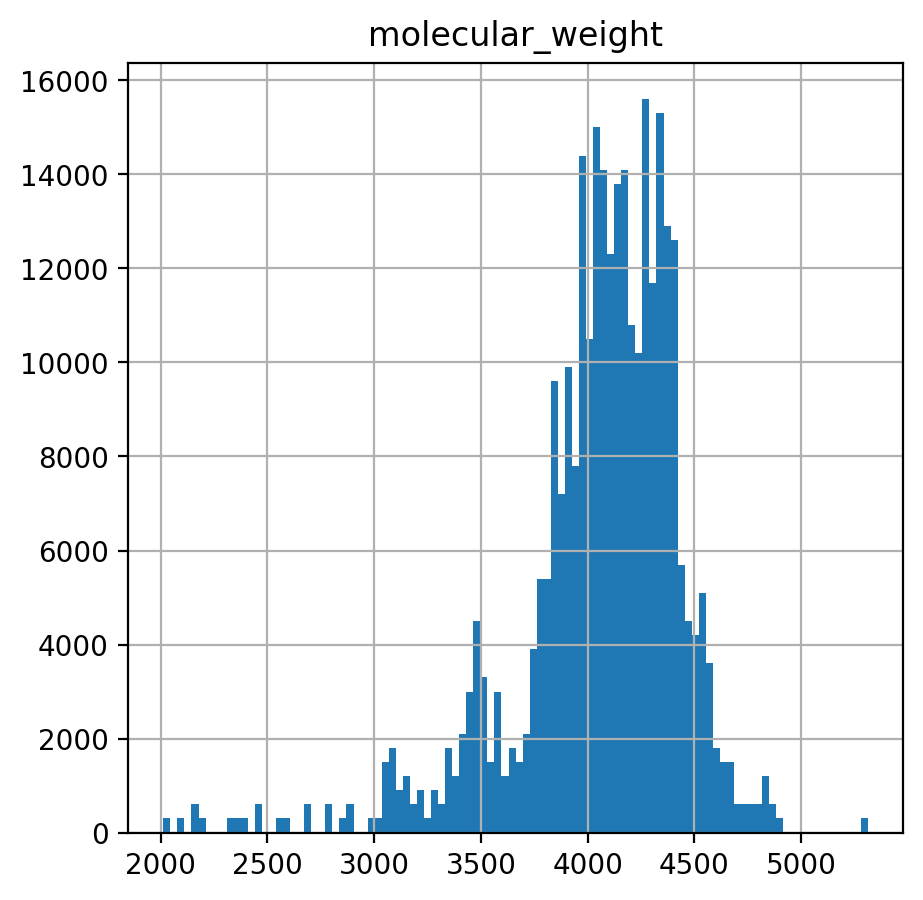

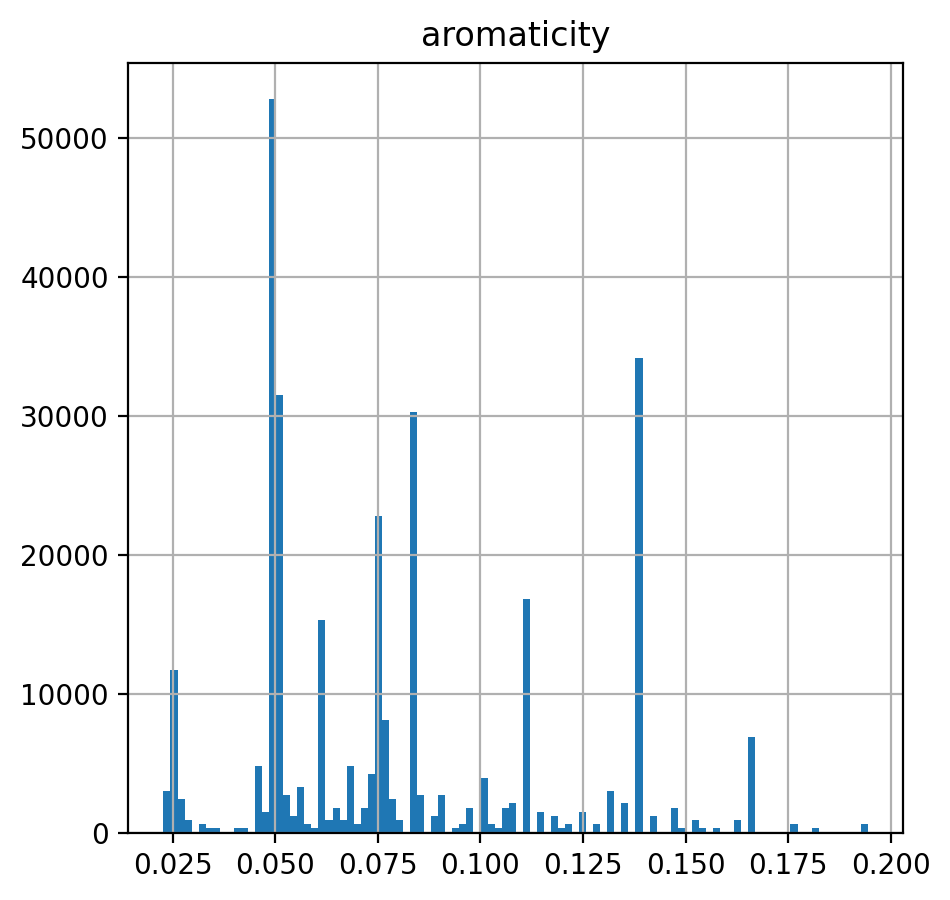

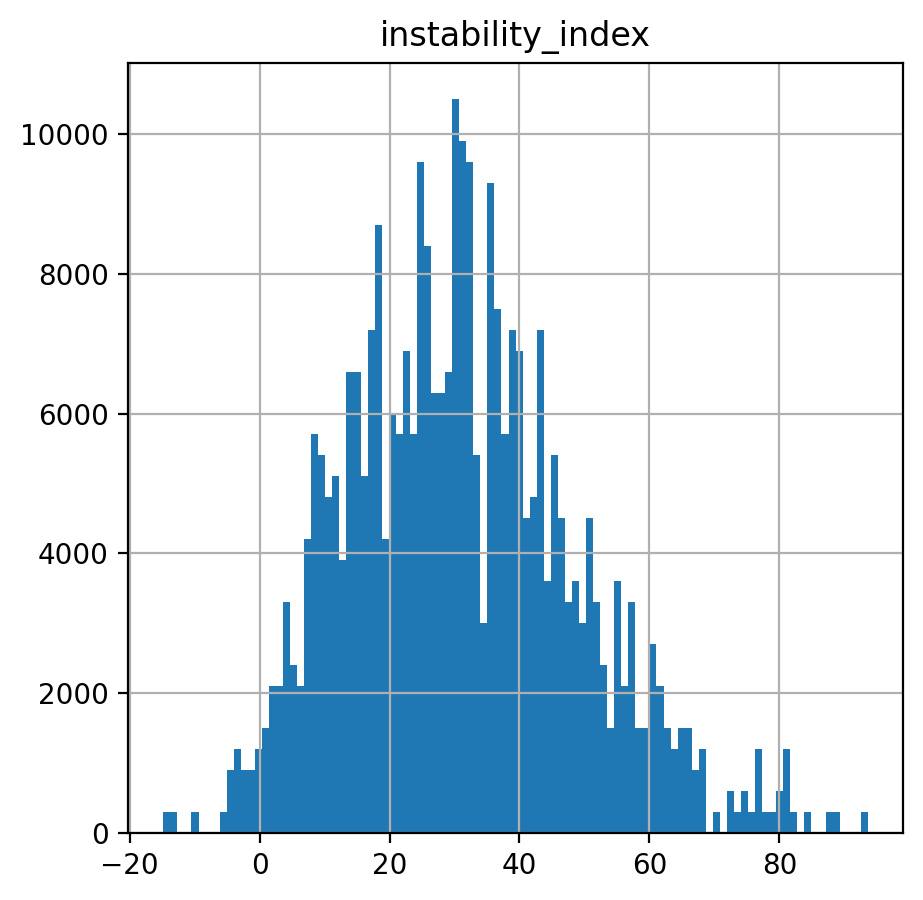

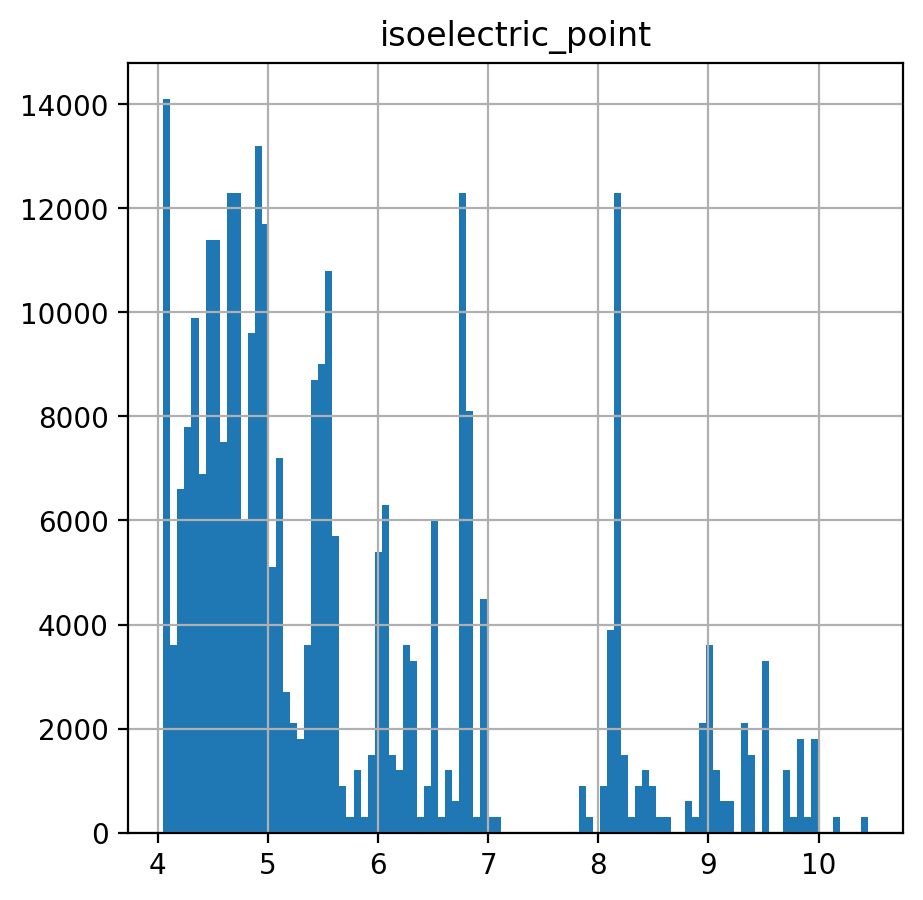

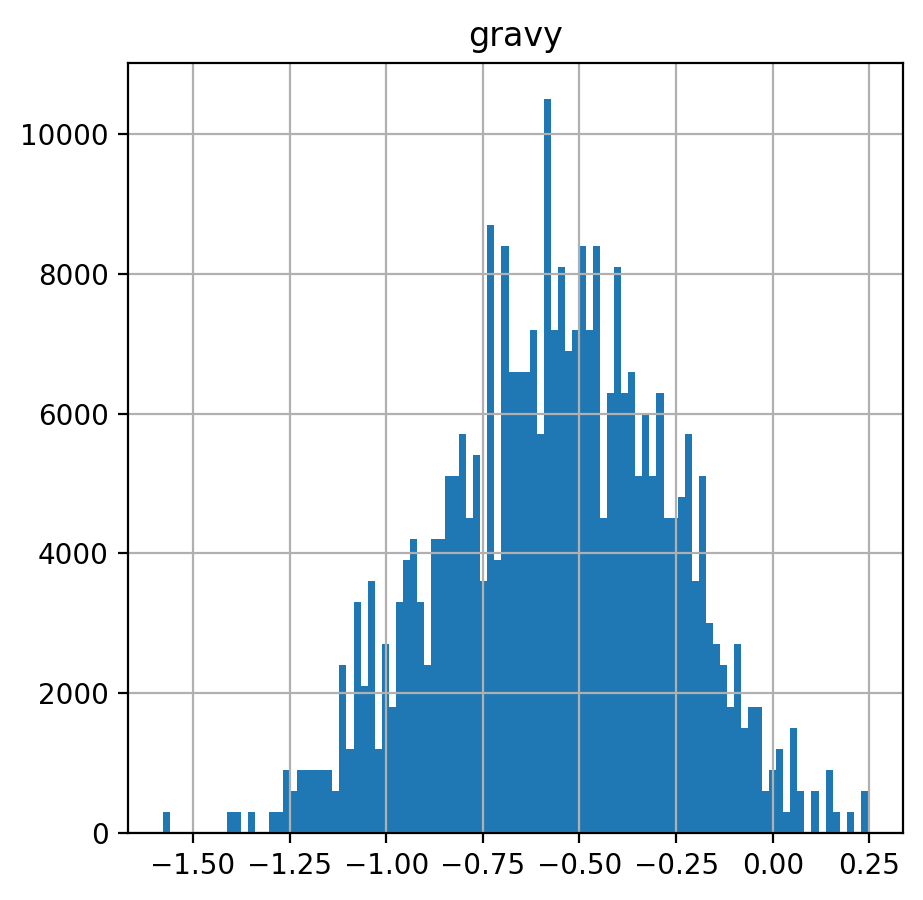

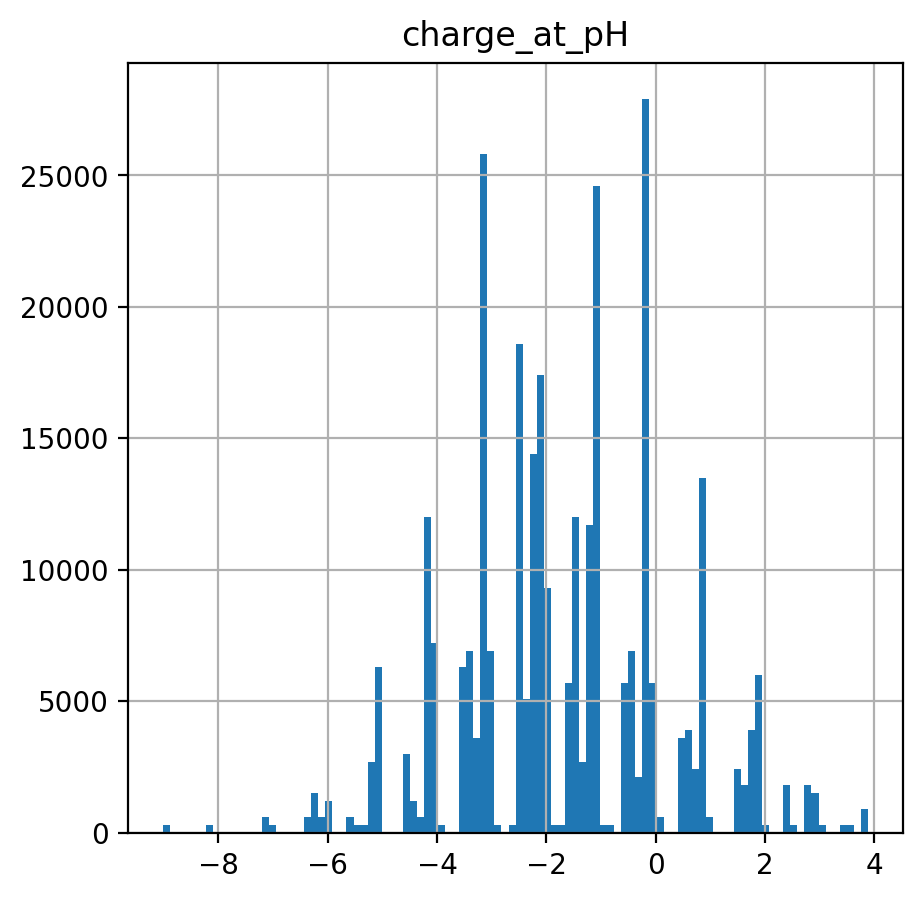

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [5.0, 5.0]
plt.rcParams['figure.dpi'] = 200

import matplotlib.pyplot as plt
from plaid.utils._protein_properties import DEFAULT_PROPERTIES

for prop in DEFAULT_PROPERTIES:
    df[prop].hist(bins=100)
    plt.title(prop)
    plt.show()

# Development & Time Benchmarking

In [42]:
restypes = set([
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
])

In [51]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd

headers, seqs = batch
df = pd.DataFrame({"sequences": seqs})

def _protein_property(protein_sequence, property):
    protein_sequence = "".join(list(filter(lambda char: char in restypes, protein_sequence)))
    analyzer = ProteinAnalysis(protein_sequence)
    if property == "charge_at_pH":
        return getattr(analyzer, property)(pH=7)
    else:
        return getattr(analyzer, property)()



In [52]:
from copy import deepcopy
df1 = deepcopy(df)
df2 = deepcopy(df)
print(df.shape)
df

(1024, 1)


,sequences
0,MEEITQIKKRLSQTVRLEGKEDLLSKKDSITNLKTEEHVSVKKMVI...
1,MKAIAWLIVLTFLPEQVAWAVDYNLRGALHGAVAPLVSAATVATDG...
2,MEILGRNLPRILGNLVKTIKTAPVRVVARRGARTLTQKEFGKYLGS...
3,MSSQESPAVEFSTTTVSSVAVQAGDSKIVIAVIKCGKWIQLQLAES...
4,PPSFIHKPDPQEVLPGSNVKFTSVVTGTAPLKVSWFKGTTELVAGR...
...,...
1019,MSTQAPTFTQPLQSVVALEGSAATFEAQVSGSPVPEVSWFRDGQVL...
1020,MATQAPTFTQPLQSVVALEGSAATFEAQISGNPVPEVSWFRDGQVL...
1021,MSTQAPTFTQPLQSVVALEGSAATFEAQVSGNPVPEVSWFRDGQVL...
1022,MSTQAPTFTQPLQNVVALEGSAATFQAQVSGSPVPEVSWFRDGQVL...


In [55]:
%%time
# no multiprocessing

for property in properties:
    df1[property] = df.sequences.map(lambda seq: _protein_property(seq, property))

CPU times: user 24.1 s, sys: 10.2 ms, total: 24.1 s
Wall time: 24.1 s


In [56]:
import multiprocessing as mp
print(mp.cpu_count())

num_processes = min(mp.cpu_count(), df.shape[0]) 
print(num_processes)

from functools import partial

def process_chunk(chunk, prop):
    return chunk.sequences.map(lambda seq: _protein_property(seq, prop))

96
96


In [57]:
%%time
for prop in properties:  
    chunk_size = len(df) // num_processes  # Size of each chunk
    chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    pool = mp.Pool(processes=num_processes)
    fn = partial(process_chunk, prop=prop)
    results = pool.map(fn, chunks)
    pool.close()
    pool.join()
    df2[prop] = pd.concat(results)

CPU times: user 1.85 s, sys: 5.12 s, total: 6.97 s
Wall time: 13.3 s


# Pfam Reference Distribution